# A short introduction to widgets

Jupyter notebooks make coding environments considerably more approachable, but periodically, it can be useful to use interactive widgets like sliders or dropdowns or similar to explore data.  For example, suppose you want to look at plots corresponding to conditions on a finite set of dates, it would be convenient to select a date of interest from a dropdown see a plot, and then select a different date and see the plot updated in place. 

In another notebook, we'll put these widgets to work to explore data, but here we'll give a quick overview of a couple. 

### Machinery under the hood

There is an evolving set of options for extending jupyter notebooks with widgets.  Here we'll focus on those supported by jupyter itself ([ipywidgets](https://ipywidgets.readthedocs.io/en/stable/index.html)). 

In [1]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pyleoclim as pyleo

In the simplest sense, we need:
- an initial object (like a figure)
- a widget
- one or more function(s) describing what to do when the widget selection has changed (for a plot this often includes instructions about whether to keep or clear actions done by the previous selection and instructions about updating according to the current selection)

Let's load some data from the Last Millenium Reanalysis Project via Pangeo-Forge, and give it a test run.

In [2]:
# Load data
import xarray as xr

store = "https://ncsa.osn.xsede.org/Pangeo/pangeo-forge/test/pangeo-forge/staged-recipes/recipe-run-1409/LMRv2p1_MCruns_ensemble_ungridded.zarr"
lmr_ds_ungridded = xr.open_dataset(store, engine='zarr', chunks={})
lmr_ds_ungridded

<xarray.Dataset>
Dimensions:              (time: 2001, MCrun: 20, members: 100, lat: 24, lon: 81)
Coordinates:
  * lat                  (lat) float32 20.0 22.0 24.0 26.0 ... 62.0 64.0 66.0
  * lon                  (lon) float32 100.0 102.0 104.0 ... 256.0 258.0 260.0
  * time                 (time) object 0000-01-01 00:00:00 ... 2000-01-01 00:...
Dimensions without coordinates: MCrun, members
Data variables:
    amo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ao                   (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    ensmean_pdo_idx      (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ensmean_pdo_pattern  (lat, lon) float32 dask.array<chunksize=(24, 81), meta=np.ndarray>
    gmt                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nao                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nhmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    nino34               (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    pdo                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    sam                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    shmt                 (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
    soi                  (time, MCrun, members) float32 dask.array<chunksize=(1, 20, 100), meta=np.ndarray>
Attributes:
    comment:                   File contains full ensemble values for each Mo...
    description:               Last Millennium Reanalysis climate field recon...
    experiment:                productionFinal2_gisgpcc_ccms4_LMRdbv1.1.0_tas
    pangeo-forge:inputs_hash:  51192b3d1b2a5bf9297cd3e6d03e1f98e202d6571545d5...
    pangeo-forge:recipe_hash:  c41d1ef8f142f43547e95f9e75160849d7554e2afaad4e...
    pangeo-forge:version:      0.9.2

That's a bunch of interesting data, but for our purpose, let's make a pandas dataframe out of a small slice of it. (It might take a minute.)

In [3]:
# Make a pandas dataframe with a few variables for ease of use
vars_subset = ['nhmt', 'shmt', 'nino34']
df = lmr_ds_ungridded.sel(MCrun=1)[vars_subset].chunk({'time':1}).groupby('time.year').mean('members').to_dataframe(dim_order=['time'])
df.index = df.index.year
df.index.name = 'year'

In [4]:
ts_d = {}
colors = ['cherryred', 'steelblue', 'coolgreen']
for ip, var in enumerate(vars_subset):
    ts_d[var] = {'series':pyleo.Series(df.index, df[var], time_unit='Year', 
                             clean_ts=False, value_name=var, 
                             value_unit = '$^{\circ}$C', label=var),
                 'color':colors[ip]}


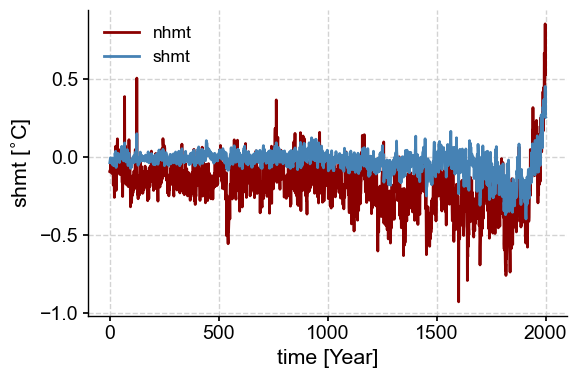

In [5]:
# Basic plot
fig, ax = plt.subplots(1,1, figsize=(6,4))
ts_d['nhmt']['series'].plot(ax=ax, legend=False, color=ts_d['nhmt']['color'])
ts_d['shmt']['series'].plot(ax=ax, legend=False, color=ts_d['shmt']['color'])
ax.legend()
plt.tight_layout()


### Base Case

#### 1.) a function to act on the data
Let's wrap the instructions about making this plot in a function that takes an input we will control with a widget.  

In [22]:
# Function to plot data
def plot(var):
    ts_d[var]['series'].plot(ax=ax0, color=ts_d[var]['color'], legend=False)
    # plt.tight_layout()
    # return ax
    
    # ax.plot(df.index, df[var], label=var)
    # configure new fig formatting
    # ax.set(**{'ylabel':var, 'xlabel':df.index.name})
    plt.tight_layout()



Now we'll make a function that clears the previous content of the plot and then runs our plotting function. If we don't do this, the figure will accumulate lines for every selection. 

In [23]:
# Function to clear previous content and update based on new selection
def update_dropdown(val):
    # clear existing content
    ax0.cla()
    
    # handle whether the input is coming from the dropdown or setup
    if type(val) == str:
        var =val
    else:
        var = val.new
    
    # plot new selection
    plot(var)
    # ax0.legend().remove()
    fig.canvas.draw_idle()

#### 2.) a widget
A good option here might be to create a dropdown of the various variables. 

In [24]:
# Initialize a dropdown widget
%matplotlib widget
dropdown = widgets.Dropdown(
    value='nhmt', 
    options=ts_d.keys(), 
    description='LMR vars', 
    layout={'width': 'initial'}
)
output = widgets.Output()
# var_list = [var for var in lmr_ds_ungridded.data_vars if 'MCrun' in lmr_ds_ungridded.data_vars[var].dims]

#### 3.) initialize the plot and turn on the widget

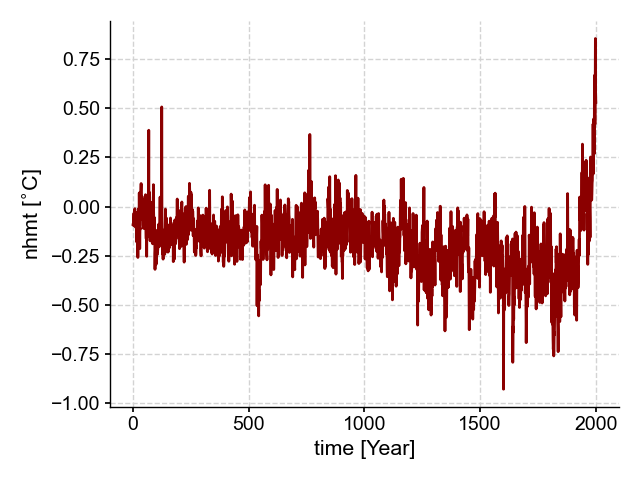

In [25]:
%matplotlib widget
plt.close('all')

# Create a figure
fig, ax0 = plt.subplots(1,1)

# Plot initial content
init_var = 'nhmt'
plot(init_var)
# ax0.legend().remove()

# Start widget "observing"
dropdown.observe(update_dropdown, 'value')
# render dropdown widget
widgets.HBox([output,dropdown])

#### Multiple widgets
It might be useful to use multiple widgets at times. For example, suppose we didn't necessarily want to clear the plot upon making a new selection, it would be handy to have a clear button. (Yes, you could easily just re-run the cell, but this makes for a simple example, and simple is often how one wants an example.)

In [26]:
# Function to plot data
def plot(var):
    ts_d[var]['series'].plot(ax=ax1, color=ts_d[var]['color'], legend=False)
    plt.tight_layout()

In [27]:
# Function to clear previous content and update based on new selection
def update_dropdown_noclear(val):
    # handle whether the input is coming from the dropdown or setup
    if type(val) == str:
        var =val
    else:
        var = val.new
    
    # plot new selection
    plot(var)
    
    ax1.set_ylabel('temp anomaly'+' [$^{\circ}$C]')
    ax1.legend()
    fig.canvas.draw_idle()

    
def on_bclear_clicked(b):
    with output:
        for line in ax1.lines: # put this before you call the 'mean' plot function.
            line.set_label(s='')
        ax1.cla()


In [28]:
# Initialize widgets
%matplotlib widget

dropdown = widgets.Dropdown(
    value='nhmt', 
    options=ts_d.keys(), 
    description='LMR vars', 
    layout={'width': 'initial'}
)
# button that will clear the plot
bclear = widgets.Button(description='Clear')

output = widgets.Output()

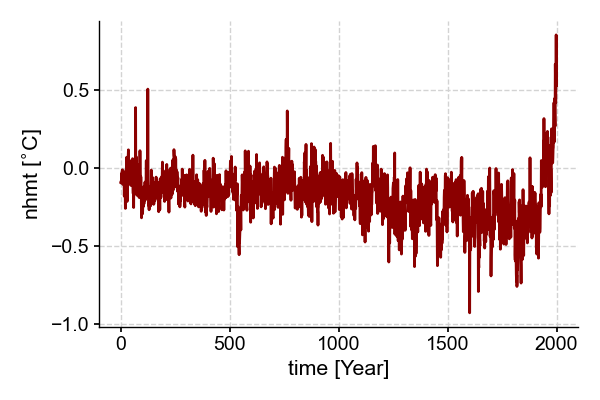

In [29]:
%matplotlib widget
plt.close('all')
fig, ax1 = plt.subplots(figsize=(6,4))
fig.subplots_adjust(bottom=0.2)

# Plot initial content
init_var = 'nhmt'
plot(init_var)

# Start widget "observing"
dropdown.observe(update_dropdown_noclear, 'value') # same dropdown, different behavior
bclear.on_click(on_bclear_clicked)

# render dropdown widget
widget_box = widgets.HBox([dropdown,bclear])
widgets.HBox([output, widget_box])


#### Final Note
There are an assortment of other widget ([options](https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html)) just waiting for investigation, but we will leave that as an exercise for the intrepid reader. 